![](https://drive.google.com/uc?export=view&id=1Wp6c0ya1zXF_UGZbgQdw8t4xcty-WTTV)

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/', force_remount=True)
%cd "/content/gdrive/MyDrive/M2 SETSIS/Deep Learning Son/repertoire_tp/2.ModelTraining"
!echo $PWD

Mounted at /content/gdrive/
/content/gdrive/MyDrive/M2 SETSIS/Deep Learning Son/repertoire_tp/2.ModelTraining
/content/gdrive/MyDrive/M2 SETSIS/Deep Learning Son/repertoire_tp/2.ModelTraining


<h1 align="left" style="color:#000051;font-size: 30px">TP : Classifiez des émotions vocales avec du deep learning</h1>

Pour ce TP, vous implémenterez un classifieur à base de réseau de neurones sur des données combinant les jeux de données RAVDESS et TESS avec la librairie keras. 
Repartez de ce notebook Jupyter qui passe en revue chaque partie du TP pour présenter des preuves et une analyse de vos résultats

<h1 align="left" style="color:#000051;font-size: 25px">Partie 2 : Développement et évaluation du modèle de deep learning</h1>

Maintenant que les données sont pré-traitées, nous nous attacherons dans cette partie à créer puis évaluer des modèles de deep learning à même d'apprendre à reconnaitre les 4 types d'émotion à partir des données dont nous disposons

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>💾 <strong>A propos des jeux de données </strong></span></h2>

Pour ce TP, nous utiliserons 2 jeux de données

- **RAVDESS : Ryerson Audio-Visual Database of Emotional Speech and Song**
https://zenodo.org/record/1188976#.X4sE0tDXKUl
  - RAVDESS a été enregistrée avec 24 acteurs professionnels (12 femmes, 12 hommes), prononçant deux phrases lexicalement identiques avec un accent nord-américain neutre. Chaque phrase est prononcée avec deux niveaux d'intensité émotionnelle (normal, fort).
  - **1440 fichiers** = 24 acteurs x 60 fichiers audio par acteur
  - **8 émotions** (neutre, calme, joie, tristesse, colère, peur, dégout, surprise).



- **TESS : Toronto Emotional Speech Set**
https://tspace.library.utoronto.ca/handle/1807/24487
  - Ces données ont été enregistrées par le Northwestern University Auditory. Un ensemble de 200 mots cibles ont été prononcés dans la phrase "Dites le mot _____" par deux actrices (âgées de 26 et 64 ans) et des enregistrements ont été réalisés lorsque ces phrases ont été prononcées avec chacune des sept émotions décrites ci-dessous.
Les deux actrices ont été recrutées dans la région de Toronto. Les deux actrices parlent l'anglais comme première langue, ont fait des études universitaires et ont une formation musicale.
  - **2800 fichiers** = 2 acteurs x 200 phrases x 7 émotions
  - **7 émotions** (neutre, joie, tristesse, colère, peur, dégoût, surprise)('calme' ne fait pas partie de cette BD) 

Pour ce TP, pour des considérations de volume de données, nous n'avons retenu que 4 des émotions:
- **neutre**
- **joie**
- **tristesse**
- **colère**

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>📥 <strong>1. Import des librairies </strong></span></h2>

Si vous avez besoin d'installer des libraires Python pour ce TP, décommentez et exécutez la cellule ci-dessous

In [ ]:
!pip3 install numpy==1.18.5
!pip3 install pydub
#!pip3 install librosa
!pip3 install noisereduce
#!pip3 install matplotlib
#!pip3 install IPython
!pip3 install tensorflow
!pip3 install scikit-learn
#!pip3 install scipy
#!pip3 install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.18.5-cp38-cp38-manylinux1_x86_64.whl (20.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
xarray-einstats 0.5.1 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
tensorflow 2.9.2 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
plotnine 0.8.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires numpy>=1.20, but you ha

In [ ]:
# Librairies de la bibliothèque standard Python
import os
import random

# Librairies de calcul numérique
import numpy as np
import pandas as pd

# Librairies de traitement audio
from pydub import AudioSegment, effects
import librosa
import soundfile as sf
from scipy.io import wavfile
import noisereduce as nr
from librosa import display   

# Librairies de data-visualization
import matplotlib.pyplot as plt
import IPython.display as ipd 
import seaborn as sns
%matplotlib inline

# Librairies de machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tensorflow.compat.v1 as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import time
import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Permute, Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Bidirectional, Conv2D
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, BatchNormalization, Reshape, MaxPooling2D, Flatten
from tensorflow.keras.utils import normalize, plot_model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>🔎 <strong>2. Chargement des données d'entrainement et labels</strong></span></h2>

Avant de commencer, chargeons les données d'entrainement et les labels que nous avons précédemment pré-traitées. 

Pour ce faire, utilisons également la librairie pickle.

In [ ]:
import pickle
with open('../1.DataPreprocessing/features.array', 'rb') as features:
    features_array = pickle.load(features)

In [ ]:
import pickle
with open('../1.DataPreprocessing/labels.array', 'rb') as labels:
    labels_array = pickle.load(labels)

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>🧮 <strong>3. Normalisation des données d'entrainement</strong></span></h2>

En machine learning, la normalisation permet de converger plus rapidement vers le minimum d'erreur et d'éviter la prédominance d'une caractéristique du jeu de données sur une autre.

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant de normaliser les données d'entrainement <strong>features_array</strong> afin de ramener les valeurs entre 0 et 1</span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
normalize
 : </span> <a href="https://www.kite.com/python/docs/sklearn.preprocessing.normalize">https://www.kite.com/python/docs/sklearn.preprocessing.normalize</a></p> 

In [ ]:
from sklearn.preprocessing import normalize
# NOTE: normalize takes only a 2D Array

# (15x184)
# Normalize on the column (axis=1) (values of each features independtly)
# la normalisation semble être faite entre -1 et 1
# Sur une colonne donnée, vmax = 1 et vmin = 0; si neg, vmax = 0 et vmin=-1
# As the lines cross multiples features, "ça n'aurait pas de sens de normaliser sur les lignes"
features_array = np.array([normalize(features_2D, axis=1) for features_2D in features_array])
print(features_array[0])

[[ 0.04529224  0.06641977  0.08263826 ...  0.          0.
   0.        ]
 [ 0.10206129  0.03297365  0.01413156 ...  0.          0.
   0.        ]
 [ 0.06080364  0.066185    0.06728106 ...  0.04467617  0.04467617
   0.04467617]
 ...
 [-0.11965876 -0.10756717 -0.08793686 ...  0.          0.
   0.        ]
 [-0.17836668 -0.17736306 -0.15851145 ...  0.          0.
   0.        ]
 [-0.1136002  -0.14004279 -0.14054925 ...  0.          0.
   0.        ]]


<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>🪓 <strong>4. Partitionnement des données</strong></span></h2>

Le jeu de données  ́etant désormais généré, il est désormais nécessaire de le structurer afin de réaliser l’apprentissage automatique du classifieur. Le jeu de données doit être réparti en :
- Un jeu de données pour l'entrainement
- Un jeu de données pour la validation
- Un jeu de données pour le test

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ En apprentissage automatique, quel est le rôle du jeu de données d’entraînement, de celui de validation et de celui de test ?</span></p>

- jeu de données d'entraînement = entraînement du modèle
- jeu de validation = étalonnage du modèle
- jeu de test = vérifier la capacité de généralisation du modèle

Pour ce faire, la librairie scikit-learn dispose de la fonction **train_test_split()** permettant de partitionner les données 

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant de partitionner les données d'entrainement <strong>features_array</strong> en sous-ensemble d'entrainement et en sous-ensemble de test. Faites attention à la répartition équitable des classes dans les données d'entrainement et de test</span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
sklearn.model_selection.train_test_split
 : </span> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html</a></p> 

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# let's make 70-30% separation
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.3, train_size=0.7)

Utilisez le code ci-dessous pour afficher la répartition des classes dans vos données, avec la supposition que vos labels d'entrainement sont dans la variable **y_train** et que vos labels de test sont dans la variable **y_test**

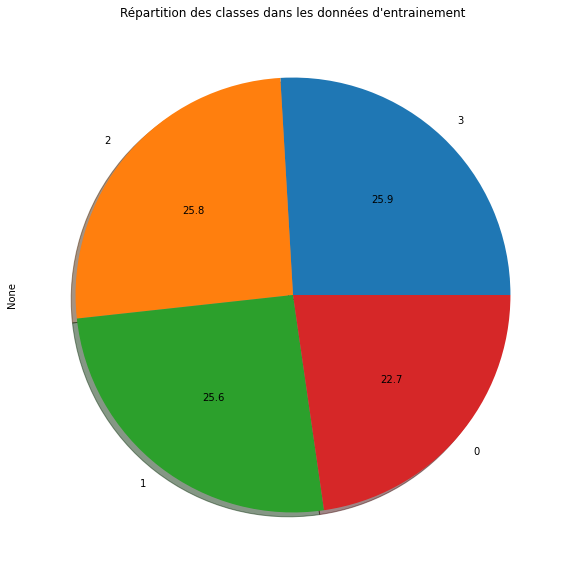

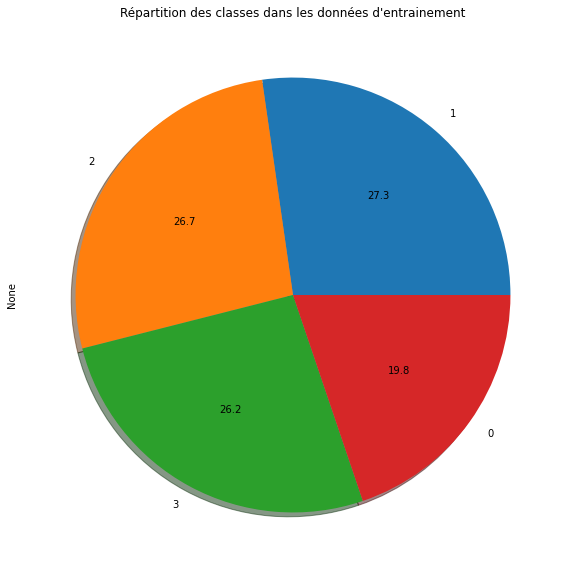

In [ ]:
import pandas as pd
y_train_series = pd.Series(y_train)
y_train_series.value_counts(normalize=True).plot(kind="pie", shadow=True, autopct="%1.1f", figsize=(12, 10), title="Répartition des classes dans les données d'entrainement")
plt.show()

y_test_series = pd.Series(y_test)
y_test_series.value_counts(normalize=True).plot(kind="pie", shadow=True, autopct="%1.1f", figsize=(12, 10), title="Répartition des classes dans les données d'entrainement")
plt.show()

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>🧠 <strong>5. Conception de modèles de deep learning</strong></span></h2>

Nous approchons du but, nous allons commencer à concevoir puis entrainer des modèles de deep learning pour modéliser notre problème de reconnaissance d'émotions.

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🧠 <strong>5.1 Définition des hyperparamètres </strong></span></h3>

Dans la conception d’un modèle de reseau de neurones, les hyperparamètres permettent de configurer differents  ́elements de l’architecture neuronale, et de superviser comment le modèle apprend

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Voici quelques hyperparamètres, savez-vous à quoi elles servent dans la conception et l’apprentissage du modèle ?</span></p>

![](https://drive.google.com/uc?export=view&id=1eaD1TrloP0gYJLnMlneiDfiggENY2BdN)

- epoch = nombre de fois qu'on présente le jeu de donnée au modèle
- batch size = découpage de jeu de donnée en batch (batch size en étant la taille) ; chaque batch (lot) sera présenté au modèle indépendamment ; cela évite de charger tout le modèle en mémoire d'un coup
- learning rate = taux d'apprentissage, définis la taille du saut lors du processus d'optimisation
- fonction d'activation = fonctions évaluées sur les combinaisons linéaires afn d'introduire de la non linéarité
ex: Relu, Sigmoid, Softmax 
- optimiseur = nom de l'algorithme qui gère la phase d'optimisation
ex: adam, sgd, rsmprop
- fonction de perte = définis la manière de calculer l'erreur
ex: erreur quadratique

Voici les valeurs des hyperparamètres à utiliser pour la conception du modèle

In [ ]:
#Model hyperparameters
BATCH_SIZE = 16
INIT_LR = 1e-3
EPOCHS = 50
ACTIVATION_FUNCTION = "relu"
LOSS_TYPE = "sparse_categorical_crossentropy"

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🧠 <strong>5.2 Définition des callbacks </strong></span></h3>

Dans Keras, les callbacks permettent de réaliser des traitements périodiques pendant l’apprentissage du modèle, au début ou à la fin de l’apprentissage, au debut ou la fin de chaque itération(epoch), au début ou à la fin de chaque batch. Les callbacks peuvent ainsi permettre d’influer sur ou d’observer l’apprentissage en cours

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Pouvez-vous expliquer comment chacun de ces callbacks influe sur le processus d’entraînement ?</span></p>

![](https://drive.google.com/uc?export=view&id=1fqMg4W9LjTOd_x-R5GOEfAj38tRUbkM9)

- TensorBoard = collecte des données et affiche un dashboard permettant de visualiser le réseau et le processus d'entrainement
- ModelCheckpoint = dump les poids à chaque epochs (paramétrables)
- ReduceLROnPlateau = réduit le learning rate lorsqu'on atteint un plateau (car peut-être un minimum local) 
- earlyStopping = définis une epoch à partir de laquelle on arrête si plus de progrès
- TerminateOnNaN = arrête l'entrainemment si on rencontre un NaN (provoqué par exemple par une division par 0, arrive lors d'une erreur dans les données)

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant de créer 4 instances de callbacks permettant de réaliser des appels de fonctions prédéfinis:  
    <ul style="text-align: left; font-size: 16px; color:#131fcf">
            <li><strong>checkpointer</strong>: doit permettre d'enregistrer à chaque epoch un fichier de poids "model.h5" dans le répertoire CHECKPOINTS_FOLDER en veillant à n'enregistrer le modèle que lorsque la précision (accuracy) s'améliore</li>
            <li><strong>reduce_lr</strong>:doit permettre de diviser par deux le learning rate à chaque fois la précision (accuracy) sur le dataset de validation ne diminue pas pendant 10 epochs, en veillant à ce que le learning ne descende jamais en dessous de 1e-10.</li>
        <li><strong>early_stop</strong>: doit permettre d'arrêter l'entraînement du modèle lorsque la précision (accuracy) sur le dataset de validation n'augmente pas pendant 25 epochs</li>
        <li><strong>tensorboard</strong>: doit permettre d'enregistrer les logs et métadonnées de l'entraînement dans le répertoire CHECKPOINTS_FOLDER</li>

</ul>
    </span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
Quick Start with Tensorflow Callbacks
 : </span> <a href="https://www.analyticsvidhya.com/blog/2021/08/quick-start-with-tensorflow-callbacks/">https://www.analyticsvidhya.com/blog/2021/08/quick-start-with-tensorflow-callbacks/

In [ ]:
CHECKPOINTS_FOLDER = "./checkpoints"

logging = tf.keras.callbacks.TensorBoard(log_dir=CHECKPOINTS_FOLDER)

# Decrease lr by 50% 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=10, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-10
)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=25, verbose=0,
    mode='auto'
)

# ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CHECKPOINTS_FOLDER, 'model.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

callbacks = [logging, reduce_lr, early_stopping, checkpoint]

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🧠 <strong>5.3 Conception de l'architecture neuronale </strong></span></h3>

Nous allons ici coder l'architecture neuronale de notre réseau. Dans Keras, bien souvent, un réseau de neurones est défini comme une séquence de couches connectées les unes aux autres. C'est pour cela que Keras propose un objet modèle appelé **Sequential()**

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>build_architecture</strong> permettant de définir séquentiellement l'architecture du réseau de neurones </span></p>

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  L'architecture neuronale à coder séquentiellement est la suivante :  

<ul style="text-align: left; font-size: 16px; color:#131fcf">
    
<strong><li>Couche convolutionnelle #1</li></strong>
    <ul>
        <li>Nombre de filtres convolutionnels : 32</li>
        <li>Taille des filtres : 15</li>
        <li>Stride : 4</li>
        <li>Fonction d'activation : relu</li>
    </ul>

<strong><li>Couche BatchNormalization</li></strong>

<strong><li>Couche convolutionnelle #2</li></strong>
    <ul>
        <li>Nombre de filtres convolutionnels : 64</li>
        <li>Taille des filtres : 15</li>
        <li>Stride : 4</li>
        <li>Fonction d'activation : relu</li>
    </ul>

<strong><li>Couche BatchNormalization</li></strong>

<strong><li>Couche convolutionnelle #3</li></strong>
    <ul>
        <li>Nombre de filtres convolutionnels : 64</li>
        <li>Taille des filtres : 15</li>
        <li>Stride : 4</li>
        <li>Fonction d'activation : relu</li>
    </ul>

<strong><li>Couche BatchNormalization</li></strong>

<strong><li>Couche reccurente LSTM #1</li></strong>
    <ul>
        <li>Nombre d'unités : 64</li>
    </ul>

<strong><li>Couche dense #1</li></strong>
    <ul>
        <li>Nombre d'unités : 64</li>
        <li>Fonction d'activation : relu</li>
    </ul>
 
<strong><li>Couche dense #2</li></strong>
    <ul>
        <li>Nombre d'unités : ?</li>
        <li>Fonction d'activation : softmax</li>
    </ul>


</span>

</p>

</ul>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
How Do Convolutional Layers Work in Deep Learning Neural Networks?
 : </span> <a href="https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/">https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/</a></p> 

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
Conv1D layer : </span> <a href="https://keras.io/api/layers/convolution_layers/convolution1d/">https://keras.io/api/layers/convolution_layers/convolution1d/</a></p> 

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
LSTM layer : </span> <a href="https://keras.io/api/layers/recurrent_layers/lstm/">https://keras.io/api/layers/recurrent_layers/lstm/</a></p> 

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
BatchNormalization layer : </span> <a href="https://keras.io/api/layers/normalization_layers/batch_normalization/">https://keras.io/api/layers/normalization_layers/batch_normalization/</a></p> 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, Conv1D, BatchNormalization

def build_architecture():
    '''
    Fonction permettant de définir l'architecture d'un réseau neuronal
            Parameters:
                    Rien
            Returns:
                    model (Keras Model Sequential) : modèle séquentiel de Keras
    '''
    # Couche Conv1D => couche prenant en compte la spatialité de la donnée
    # Note: tout signal est une donnée spatiale, c'est probablement plus frappant pour les images
    # Couche Dense => prennent en compte le caractère séquentiel
    # Couche de BatchNormalization => évite la saturation

    model = Sequential()
    # Define the first layer (input layer)
    # Its shape will be (15,184), for Keras => (None, 15, 184) de façon à pouvoir faire "glisser" le batch size
    # Si le batch size est à 16, alors cela signifie que tour à tour, ce sera (Batch_size, 15, 184) qui sera évalué
    model.add(tf.keras.layers.Conv1D(32, kernel_size=15, strides=4, activation='relu', input_shape=(X_train.shape[1:3])))
    # Batch normalization = permet de compresser la dynamique des poids de façon à éviter la saturation
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Conv1D(64, kernel_size=15, strides=4, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Conv1D(64, kernel_size=15, strides=4, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    return model

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'afficher l'architecture du modèle </span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
How to Visualize a Deep Learning Neural Network Model in Keras : </span> <a href="https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/">https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/</a></p> 

In [ ]:
model = build_architecture()

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🧠 <strong>5.4 Compilation de l'architecture neuronale </strong></span></h3>

Maintenant que le modèle est défini, nous pouvons le compiler.

La compilation du modèle utilise les bibliothèques numériques efficaces en back-end telles que Theano ou TensorFlow. Le backend choisit automatiquement la meilleure façon de représenter le réseau pour l'entrainement et de faire des prédictions. La compilation découvre également sur quel matériel de votre ordinateur exécuter les différents calculs nécessaires pendant l'entrainement et la prédiction : CPU ou GPU.

Lors de la compilation, nous devons spécifier certaines propriétés supplémentaires requises lors de l'entrainement du réseau. N'oubliez pas qu'entrainer un réseau signifie trouver le meilleur ensemble de poids pour approximer les entrées aux sorties dans notre ensemble de données.

Nous devons spécifier :
- la fonction de perte à utiliser pour évaluer l'erreur, 
- l'optimiseur qui sera utilisé pour les valeurs de poids qui minimisent la fonction de perte 
- toutes les métriques que nous aimerions collecter et monitorer pendant l'entrainement.

![](https://drive.google.com/uc?export=view&id=1Y5ew5b1sZOw7OeWos6_j7TCWc6ZAeK00)

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant de compiler l'architecture du réseau de neurones en utilisant une partie des hyperparamètres définis plus haut. Monitorez la métrique accuracy</span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
How to compile a keras model? : </span> <a href="https://www.projectpro.io/recipes/compile-keras-model">https://www.projectpro.io/recipes/compile-keras-model/</a></p> 

In [ ]:
# loss dépend du problème, du nombre de classe (on utiliserait plutôt binary cross entropy si le nombre de classe = 2 par exemple) et de comment les labels sont encodés
# l'optimizer est plutôt générique
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🧠 <strong>5.5 Entrainement du modèle </strong></span></h3>

Nous avons défini notre modèle et l'avons compilé pour un calcul efficace. Il est maintenant temps d'exécuter l'entrainement du modèle sur certaines données.

Nous pouvons entraîner notre modèle sur nos données en appelant la fonction **fit()** sur le modèle.

![](https://drive.google.com/uc?export=view&id=1w0KQf0njxtYuXY4cqy4aZ8RvjLxb_IN6)

L'entrainement se déroule sur des "epoch" et chaque "epoch" est divisée en "batch".

- "epoch" : Itération complète correspondant au traitement de toutes les données du jeu de données d'apprentissage par le modèle.
- "batch" : Lot de plusieurs données soumis séquentiellement au modèle au cours d'une "epoch" avant que les poids ne soient mis à jour.

Une "epoch" est composée d'un ou plusieurs "batch" en fonction de la taille de "batch" choisie. Le modèle est entrainé sur plusieurs "epoch".

- Le processus d'apprentissage s'exécutera donc pendant un nombre fixe d'itérations à travers l'ensemble de données appelé epochs, que nous devons spécifier à l'aide de l'argument epochs. 
- Nous devons également définir la taille des batchs à l'aide de l'argument batch_size.

Nous voulons entraîner suffisamment le modèle pour qu'il apprenne une bonnne (ou assez bonne) approximation des données d'entrées. Le modèle aura toujours une erreur, mais la quantité d'erreur se stabilisera à un certain moment pour une configuration de modèle donnée. **C'est ce qu'on appelle la convergence des modèles. **

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'entrainer le réseau de neurones convolutionnel et recuurent défini et compilé. 
    Lancez l'entrainement pendant 50 itérations, en appliquant la liste de callbacks précédemment définis. Récupérez l'historique de l'entrainement dans la variable training_history

 </span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
Visualizing training performance with TensorFlow 2 and Keras : </span> <a href="https://www.machinecurve.com/index.php/2019/10/08/how-to-visualize-the-training-process-in-keras/">https://www.machinecurve.com/index.php/2019/10/08/how-to-visualize-the-training-process-in-keras/</a></p> 

In [ ]:
# on en profite pour repartitionner le train test: 10% du train test sera consacré à la validation 
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, callbacks=callbacks)

Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 0.8528 - accuracy: 0.6832
Epoch 1: val_accuracy improved from -inf to 0.36478, saving model to ./checkpoints/model.h5
90/90 [==============================] - 7s 26ms/step - loss: 0.8528 - accuracy: 0.6832 - val_loss: 1.2976 - val_accuracy: 0.3648 - lr: 0.0010
Epoch 2/50
89/90 [============================>.] - ETA: 0s - loss: 0.4249 - accuracy: 0.8448
Epoch 2: val_accuracy improved from 0.36478 to 0.79874, saving model to ./checkpoints/model.h5
90/90 [==============================] - 4s 47ms/step - loss: 0.4238 - accuracy: 0.8455 - val_loss: 0.8901 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.8601
Epoch 3: val_accuracy improved from 0.79874 to 0.81761, saving model to ./checkpoints/model.h5
90/90 [==============================] - 3s 38ms/step - loss: 0.3538 - accuracy: 0.8601 - val_loss: 0.4822 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 4

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>📈<strong>6. Visualisation des courbes d'apprentissage</strong></span></h2>

Maintenant que l'entrainement est terminé, il est important de voir comment s'est passé l'apprentissage. Il est possible de visualiser la dynamique de l'entrainement en visualisant les courbes d'apprentissage.

In [ ]:
def plot_results(training_history):
    '''
    Fonction permettant d'afficher les courbes d'apprentissage du modèle sur les données d'entrainement

            Parameters:
                    training_history (History object): Un objet d'histoire. Son attribut History.history est 
                                                       un enregistrement des valeurs de perte d'entraînement et 
                                                       des valeurs de métriques à des épochs successives, ainsi
                                                       que des valeurs de perte de validation et des valeurs de 
                                                       métriques de validation
            Returns:
                    Rien
    '''
    
    plt.plot(training_history.history['accuracy'])
    # if tensorflow 2 => val_acc
    plt.plot(training_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(training_history.history['loss'])
    plt.plot(training_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc = 'upper left')
    plt.show()

L'overfitting (ou sur-apprentissage) apparait lorsque le modèle est trop spécialisé sur le jeu d'entrainement et perd ainsi sa capacité de généralisation. Une différence notable avec l'accuracy du jeu de validation apparait alors. 

Note: pour contrer l'overfitting:

=> Arrêter l'entrainement au bon moment (nombre correct d'epoch)

=> diversification du dataset: augmentation en quantité et en qualité.

=> utilisation du dropout qui va désactiver certaine partie du réseau lors de l'apprentissage et ainsi permettre de mieux le généraliser.

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Appelez la fonction plot_results avec comme argument l'historique de l'entrainement pour afficher les courbes d'apprentissage </span></p>

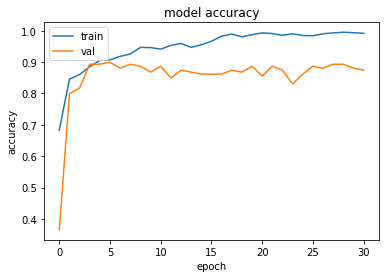

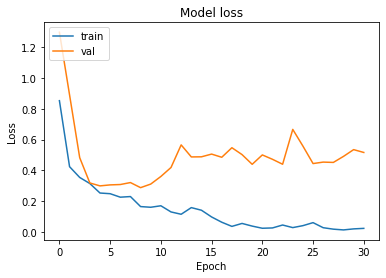

In [ ]:
plot_results(history)

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>👨🏽‍🏫 <strong>7. Evaluation du modèle</strong></span></h2>

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>👨🏽‍🏫 <strong>7.1 Evaluation empirique sur le jeu de données de test </strong></span></h3>

Nous avons entrainé notre réseau de neurones sur le jeu de données et nous pouvons évaluer les performances du réseau sur le jeu de données de test

Vous pouvez évaluer votre modèle  à l'aide de la fonction **evaluate()**.

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'évaluer les performances du modèle sur les données de test</span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
How to evaluate a keras model? : </span> <a href="https://www.projectpro.io/recipes/evaluate-keras-model">https://www.projectpro.io/recipes/evaluate-keras-model</a></p> 

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

22/22 [==============================] - 0s 6ms/step - loss: 0.6710 - accuracy: 0.8519
Test loss: 0.6710477471351624
Test accuracy: 0.8519061803817749


<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Que sont les deux valeurs renvoyées par l'évaluation du modèle ?</span></p>

loss = somme d'erreur, pas un pourcentage (erreur quadratique par exemple), n'est pas vraiment significatif tout seul => il faut la comparer avec d'autres raisons

accuracy = pourcentage de bonne prédiction

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>👨🏽‍🏫 <strong>7.2 Calcul de la matrice de confusion </strong></span></h3>

In [ ]:
EMOTION_DICT = {0:"neutre", 1:"joie", 2:"tristesse", 3:"colere"}
labels = list(EMOTION_DICT.values())

Allons un peu plus dans le détail de la performance du modèle sur le jeu de données de test. Regardons sur quelle classe le modèle se trompe et avec quelles classes la confusion est la plus grande. Cela peut se faire via une matrice de confusion

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>compute_confusion_matrix</strong> permettant de calculer et d'afficher la matrice de confusion puis appelez cette fonction sur les données de test </span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
Generate classification report and confusion matrix in Python : </span> <a href="https://www.projectpro.io/recipes/generate-classification-report-and-confusion-matrix-in-python">https://www.projectpro.io/recipes/generate-classification-report-and-confusion-matrix-in-python</a></p> 

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
sklearn.metrics.ConfusionMatrixDisplay : </span> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html">https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html</a></p> 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_confusion_matrix(model : Sequential, X_test, y_test):
    '''
    Fonction pour calculer et afficher la matrice de confusion

            Parameters:
                    model (Keras Model): Modèle Keras entrainé sur le jeu d'entrainé 

            Returns:
                    Rien : affiche la matrice de confusion
    '''
    y_pred = model.predict(X_test)
    # y_pred is composed of 682 lines of [Y0, Y1, Y2, Y3] where Yi is the probability of 
    # being in a given class (index of Yi in the list mapped to one of the EMOTION_DICT.keys())
    y_pred = [list(prediction).index(max(prediction)) for prediction in y_pred]
    # much better version of the previous line:
    # y_pred = [np.argmax(elt) for elt in y_pred]
    cm = confusion_matrix(y_test, y_pred, labels=list(EMOTION_DICT.keys()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot()
    plt.show()


22/22 [==============================] - 0s 3ms/step


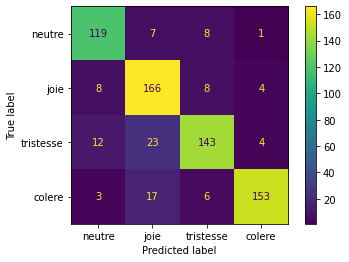

In [ ]:
compute_confusion_matrix(model, X_test, y_test)

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Pour chaque classe d'émotion, avec quelle émotion la confusion du modèle est la plus grande (en d'autres termes, quelle émotion est la plus représentée dans les erreurs de prédiction pour chaque émotion ?</span></p>

- neutre avec tristesse
- joie avec tristesse
- tristesse avec colère
- colère avec joie

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def compute_classification_report(model : Sequential, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(elt) for elt in y_pred]
    results = classification_report(y_test, y_pred)
    print(results)

In [ ]:
compute_classification_report(model, X_test, y_test)

22/22 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       135
           1       0.78      0.89      0.83       186
           2       0.87      0.79      0.82       182
           3       0.94      0.85      0.90       179

    accuracy                           0.85       682
   macro avg       0.86      0.85      0.85       682
weighted avg       0.86      0.85      0.85       682



Dans le cas où le jeu de donnée est déséquilibré, l'accuracy peut induire en erreur. Dans ce cas, utiliser la matrice de confusion / ROC_AUC.

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>
📼 <strong>8. Sauvegarde du modèle entrainé</strong></span></h2>

Nous allons ici sauvegarder sur notre disque le modèle que nous avons entrainé en vue d'une utilisation ultérieure.

Pour ce faire, nous utiliserons la fonction save de keras qui permet d'enregistrer des modèles.

In [ ]:
model.save('./model.h5')

In [3]:
 %%shell
jupyter nbconvert --to html ModelTraining.ipynb

[NbConvertApp] Converting notebook ModelTraining.ipynb to html
/usr/local/lib/python3.8/dist-packages/nbconvert/filters/datatypefilter.py:39: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Writing 521761 bytes to ModelTraining.html
